In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

import utils

递归神经网络(RNN)主要用于序列数据的处理，比方说自然语言组成的句子。这类数据的样本间存在顺序关系。每个样本都和之前都样本存在关联。

考虑到这种关联性，RNN依照顺序处理序列$\{x_0, x_1, x_2, \dots\}$，并将一部分信息传递下去。具体来说，RNN在每个token $x_i$处应用一个神经元函数 $f$, 得到$o_i$和$h_i$。其中$o_i$是这个token的输出，$h_i$作为下一个token $x_{t+1}$处的输入起到信息传递的作用。即，

$$(h_i, o_i) = f(h_{i-1}, x_i)$$

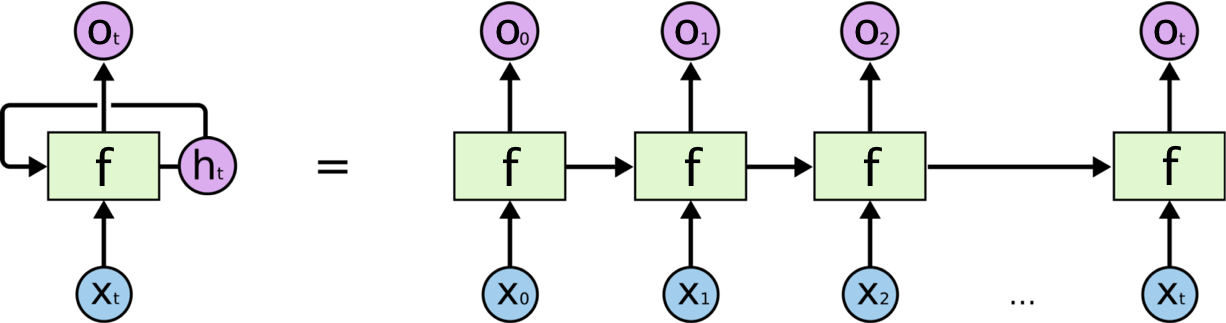

这个教程里，我们写一个简单的递归神经网络来生成中文名字（拼音）。每一步的输出$O_i$代表了下一个值的分布。比方说，对于名字 `"XiaoMing"`，在字母 `"n"` 处，神经网络已经处理了 `"XiaoMi"`，输入是 `"n"`，我们希望它可以预测下一个token有大概率是 `"g"`。

训练了这样一个网络之后，我们就可以每一步从它的输出里采样一个值，来生成中文名字。

## 数据处理

In [22]:
# 中文名字数据
names = torch.load('names.pth')
print(names[70])

JiaYi


### 将字符串名字拼音转换成数字
```
# A -> 0
# B -> 1
# ...
# Z -> 25
# a -> 26
# ...
# z -> 51
# End of String -> 52 代表字符串结束
```
总共53个token。

In [23]:
# 总token数量
volcab_size = 53

In [24]:
numbers = utils.string_to_numbers(names[70])
print(numbers)
print(utils.numbers_to_string(numbers))

[9, 34, 26, 24, 34, 52]
JiaYi<EoS>


In [25]:
# 数据库
class NamesDataset(torch.utils.data.Dataset):
    def __init__(self, data, volcab_size):
        self.data = data
        self.volcab_size = volcab_size
        
    def __getitem__(self, i):
        name = self.data[i]
        # 转换成ascii数字
        numbers = utils.string_to_numbers(name)
        inputs = numbers[:-1]
        target = numbers[1:]
        # 转换成one-hot向量。比方说 4 -> [0, 0, 0, 1, 0, ...]
        return utils.to_one_hot(inputs, self.volcab_size), torch.tensor(target)
        
    def __len__(self):
        return len(self.data)
    
dataset = NamesDataset(names, volcab_size)
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=2)

In [26]:
# 看一下数据
inputs, target = dataset[2]
print("输入数据（one-hot向量）：", inputs)
print("输入数据（数字）：", inputs.argmax(1))  # 在one-hot向量上取argmax即可得到原来的数字
print("预测目标（数字）：", target)            # 每一步训练的目标
print("输入数据（拼音）：", utils.numbers_to_string(inputs.argmax(1)))
print("预测目标（拼音）：", utils.numbers_to_string(target))

输入数据（one-hot向量）： tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

比方说在第一步，输入是 `"Y"`，我们的预测目标是 `"u"`。

## 定义递归神经元（即函数 $f$ )

这里定义f(x_i, h_i)成一个简单的神经元函数：
```
h_i: [x_i, h_{i-1}] -> 全联接层1 -> tanh        -> h_i
o_i: [x_i, h_i]     -> 全联接层2 -> log softmax -> o_i  # 之后会用负对数似然损失函数
```

In [27]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # input_size 是输入 x_i 的size
        # hidden_size 是每个 h_i 的size
        super(RNNCell, self).__init__()
        # 全联接层的输入是 x_i 和 h_{i-1}
        self.linear1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear2 = nn.Linear(input_size + hidden_size, output_size)
        
    def forward(self, input, h_prev):
        # input是x_i,       [B x input_size]
        # h_prev是h_{i-1}   [B x hidden_size]
        # B 是 batch size 我们这里默认为1
        #
        # 先使用torch.cat 将 x_i 和 h_{i-1} 合并成一个Tensor
        combined_input = torch.cat([input, h_prev], dim=1)
        # FIXME: 计算h_i
        h_i = self.linear1(combined_input).tanh()
        # FIXME: 合并h_i和input，并计算o_i
        o_i = self.linear2(torch.cat([input, h_i], dim=1))
        o_i = F.log_softmax(o_i, dim=-1)  # 计算log_softmax
        return h_i, o_i

In [28]:
# 建立递归神经网络模型
input_size = volcab_size
hidden_size = 80
output_size = volcab_size
cell = RNNCell(input_size, hidden_size, output_size)
# 使用Adam优化器
optim = torch.optim.Adam(cell.parameters(), lr=0.003)

## 训练

<IPython.core.display.Javascript object>


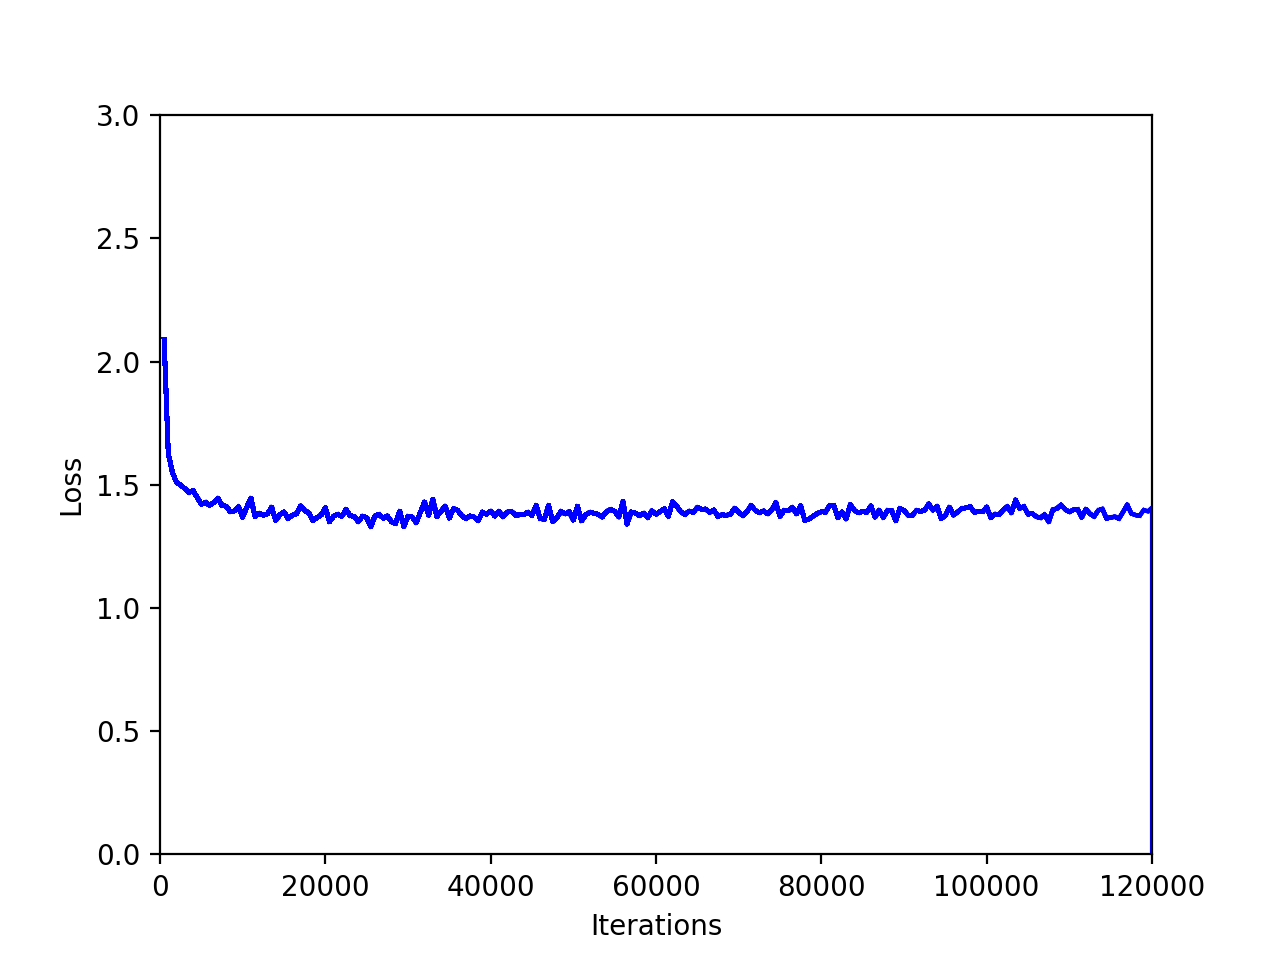

In [29]:
num_epochs = 1  # 因为这个数据集很大，我们只训练一个epoch

# 一些绘图设定
plotter = utils.SmoothPlotter(500)
plotter.ax.set_xlabel('Iterations')
plotter.ax.set_ylabel('Loss')
plotter.ax.set_xlim(0, num_epochs * len(dataloader))
plotter.ax.set_ylim(0, 3)

for epoch in range(num_epochs):
    for inputs, target in dataloader:
        loss = 0
        optim.zero_grad()
        h = torch.zeros(1, hidden_size)
        for i in range(inputs.size(1)):
            h, o = cell(inputs[:, i], h)
            loss += F.nll_loss(o, target[:, i])  # 积累这一步的负对数似然损失函数
        loss.backward()  # 求导
        optim.step() # 优化
        plotter.update(loss.item() / inputs.size(1))
        
plotter.finish()

## 来试试训练的结果

下面的 `sample` 函数根据提供的一个前缀来通过训练好的模型进行采样

In [30]:
def sample(prefix='A'):
    samples = utils.string_to_numbers(prefix)[:-1]
    h = torch.zeros(1, hidden_size)
    with torch.no_grad():
        for sample in samples:
            input = utils.to_one_hot([sample], 53)
            h, o = cell(input, h)
        while sample != 52:
            input = utils.to_one_hot([sample], 53)
            h, o = cell(input, h)
            sample = torch.multinomial(o.exp(), 1).item()
            samples.append(sample)

    return utils.numbers_to_string(samples)

In [31]:
sample('D')

'DaoHai<EoS>'